## Creating a function that changes the resolution of any grid and then visualizes it.

In [1]:
import geopandas as gpd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
#import os

In [2]:
gdf = gpd.read_file(r'C:\Users\Ankit\Documents\Vedanshi\ML-hands-on\course_work\shp_rohit\alknanda.shp')
gdf=gdf.to_crs(3857)

In [3]:
gdf.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

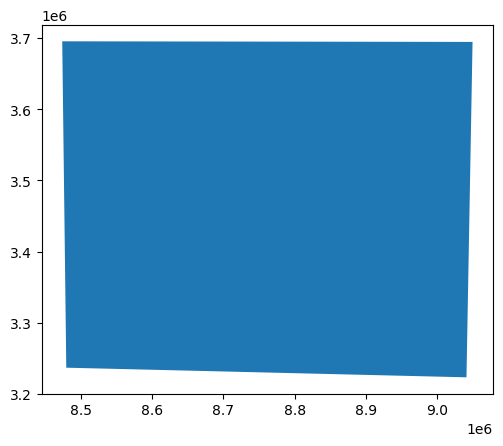

In [4]:
gdf.plot()

In [5]:
bound_box=gdf.total_bounds
minx,miny,maxx,maxy=bound_box

In [6]:
from shapely.geometry import box
# Create a rectangle from these coordinates using shapely's box function
rectangle = gpd.GeoSeries([box(minx, miny, maxx, maxy)], crs='epsg:32633')
# Print the rectangle coordinates
print(f"Bounding Box Coordinates: {bound_box}")
print(f"Rectangle Geometry: {rectangle}")

Bounding Box Coordinates: [8473309.19240001 3223276.94830593 9050145.89719386 3695645.4295    ]
Rectangle Geometry: 0    POLYGON ((9050145.897 3223276.948, 9050145.897...
dtype: geometry


<Axes: >

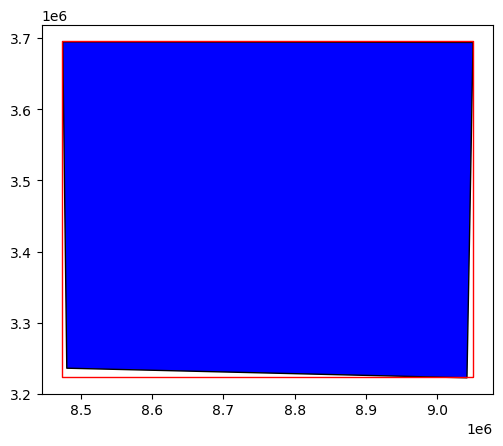

In [7]:
ax = gdf.plot(color='blue', edgecolor='k')
rectangle.plot(ax=ax, color='none', edgecolor='red')

In [8]:
polygon=gdf.geometry[0]
coordinates = list(polygon.exterior.coords)
coordinates.remove(coordinates[4])
coordinates

[(9050145.89719386, 3694791.2934906688),
 (9041610.152218213, 3223276.9483059347),
 (8479000.754500005, 3236800.55559999),
 (8473309.192400012, 3695645.429500003)]

In [9]:
maxx=9050145.89719386-100
miny=3236800.55559999+1000
miny

3237800.55559999

Bounding Box Coordinates: [8473309.19240001 3223276.94830593 9050145.89719386 3695645.4295    ]
Rectangle Geometry: 0    POLYGON ((9050045.897 3237800.556, 9050045.897...
dtype: geometry


<Axes: >

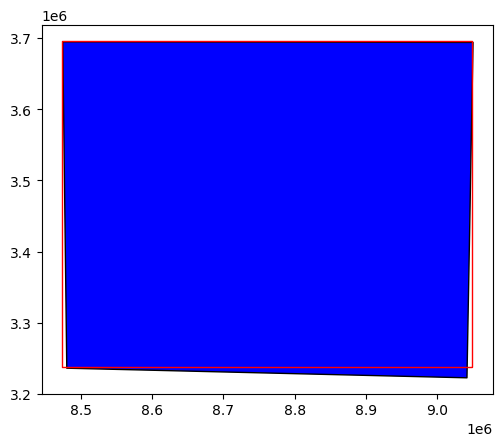

In [10]:
from shapely.geometry import box
# Create a rectangle from these coordinates using shapely's box function
rectangle = gpd.GeoSeries([box(minx, miny, maxx, maxy)], crs='epsg:3857')
# Print the rectangle coordinates
print(f"Bounding Box Coordinates: {bound_box}")
print(f"Rectangle Geometry: {rectangle}")
ax = gdf.plot(color='blue', edgecolor='k')
rectangle.plot(ax=ax, color='none', edgecolor='red')

In [11]:
# function to calculate grid parameters
def calculate_grid_parameters(coord):
    d = np.diff(coord)[0] / 2
    cell_boundaries = np.concatenate([[coord[0] - d], coord + d])
    return cell_boundaries

In [12]:
# function to create grid cell taking arguments from x_values and y_values
def initialize_and_populate_grid(x_values, y_values):
    ngrid_cell = len(x_values) * len(y_values)
    grid_cell = [{} for _ in range(ngrid_cell)]
    
    dy = y_values[1] - y_values[0]
    k = 0
    
    loncell = calculate_grid_parameters(x_values)
    latcell = calculate_grid_parameters(y_values)
    
    for i, lon in enumerate(x_values):
        for j, lat in enumerate(y_values):
            x_coords = [round(loncell[i], 2), round(loncell[i], 2), round(loncell[i+1], 2), round(loncell[i+1], 2), round(loncell[i], 2)]
            y_coords = [round(latcell[j], 2), round(latcell[j+1], 2), round(latcell[j+1], 2), round(latcell[j], 2), round(latcell[j], 2)] if dy > 0 else \
                       [round(latcell[j+1], 2), round(latcell[j], 2), round(latcell[j], 2), round(latcell[j+1], 2), round(latcell[j+1], 2)]
            
            grid_cell[k] = {'X':x_coords,'Y':y_coords,'Xc': round(lon, 2), 'Yc': round(lat, 2)}
            k += 1
    return grid_cell

In [13]:
def res_change(minx, miny, maxx, maxy, input_res, output_res):
    '''returns the x and y coordinates of centroids for the input and output resolution grid, in the order of 
    x,y being the x and y coordinates of the centroids of the grid cells for the input resolution grid and x_out,y_out being the x and y coordinates of the centroids of the grid cells for the output resolution grid.
    the function also returns the grid for output resolution.
    it also visualizes the grid for input and output resolution.'''
    
    if ((maxx-minx)*(maxy-miny)!=((input_res/output_res)**2)*(maxx-minx)*(maxy-miny)):
        print("The resolution change is not exact.")
        #back_calc((minx, miny, maxx, maxy))
        
    else:
        print("The resolution change is exact.")

    # Generate x-values for the input resolution grid
    x_values = []
    current_x = minx
    while current_x < maxx:
        x_values.append(current_x)
        current_x += input_res
    
    # Generate y-values for the input resolution grid
    y_values = []
    current_y = miny
    while current_y < maxy:
        y_values.append(current_y)
        current_y += input_res
    
    x_values = np.array(x_values, dtype=float)
    y_values = np.array(y_values, dtype=float)
    
    grid_cell = initialize_and_populate_grid(x_values, y_values)
    xc = [i['Xc'] for i in grid_cell]
    yc = [i['Yc'] for i in grid_cell]
    x, y = np.meshgrid(xc, yc)
    
    
    rectangle = gpd.GeoSeries([box(minx, miny, maxx, maxy)], crs='epsg:3857')
    fig, ax = plt.subplots()
    ax.scatter(x, y, s=1, color='blue')
    rectangle.plot(ax=ax, color='none', edgecolor='red')
    plt.title('Image for input resolution')
    plt.show()
    
    # Generate x-values for the output resolution grid
    x_values_output = []
    current_x_output = minx
    while current_x_output < maxx:
        x_values_output.append(current_x_output)
        current_x_output += output_res
    
    # Generate y-values for the output resolution grid
    y_values_output = []
    current_y_output = miny
    while current_y_output < maxy:
        y_values_output.append(current_y_output)
        current_y_output += output_res
    
    x_values_output = np.array(x_values_output, dtype=float)
    y_values_output = np.array(y_values_output, dtype=float)
    
    grid_cell_output = initialize_and_populate_grid(x_values_output, y_values_output)
    xc_output = [i['Xc'] for i in grid_cell_output]
    yc_output = [i['Yc'] for i in grid_cell_output]
    x_out, y_out = np.meshgrid(xc_output, yc_output)
    
    rectangle_out = gpd.GeoSeries([box(minx, miny, maxx, maxy)], crs='epsg:3857')
    fig_out, ax_out = plt.subplots()
    ax_out.scatter(x_out, y_out, s=1, color='black')
    rectangle_out.plot(ax=ax_out, color='none', edgecolor='red')
    plt.title('Image for output resolution')
    plt.show()
    print("lenghts of x_values,y_values,x_values_output,y_values_output: ",len(x_values), len(y_values), len(x_values_output), len(y_values_output))
    return x,y,x_out,y_out,grid_cell_output


## Reading the shape file and trying to fit it in the grid

In [14]:
#importing the required libraries
import geopandas as gpd 
import pandas as pd
import numpy as np
from shapely.geometry import Polygon

<Axes: >

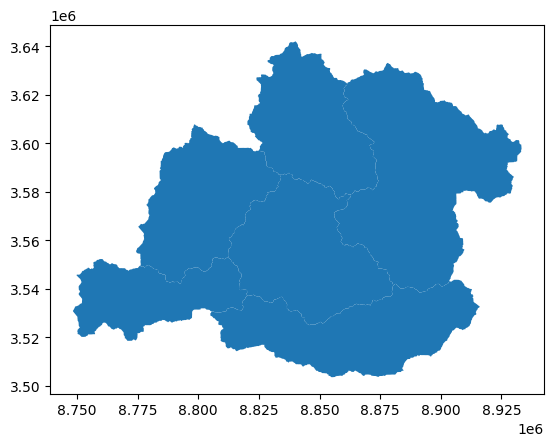

In [15]:
#reading and fitting the shapefile onto the created grid
pth=r'C:\Users\Ankit\Documents\Vedanshi\ML-hands-on\Shapefile_alakananda-20240627T070711Z-001\Shapefile_alakananda\alak_shape_all_84.shp'
shape_file = gpd.read_file(pth)
shape_file=shape_file.to_crs(3857)
shape_file.plot()

In [16]:
bounding_box=shape_file.total_bounds
bounding_box

array([8748302.15014448, 3503554.79441182, 8933323.86203855,
       3642097.17433683])

In [17]:
new_bounds=[minx,miny,maxx,maxy]
new_bounds-bounding_box

array([-274992.95774446, -265754.23881183,  116722.03515531,
         53548.25516317])

In [18]:
#manully changing the bounding box to fit the shapefile with approximately +10km on evey side.
minx+=264992.95774446
miny+=255754.23881183
maxx-=106722.03515531
maxy-=51548.25516317
new_bounds=[minx,miny,maxx,maxy]
print(new_bounds-bounding_box)
new_bounds

[-10000. -10000.  10000.   2000.]


[np.float64(8738302.150144473),
 3493554.79441182,
 8943323.86203855,
 np.float64(3644097.174336833)]

The resolution change is not exact.


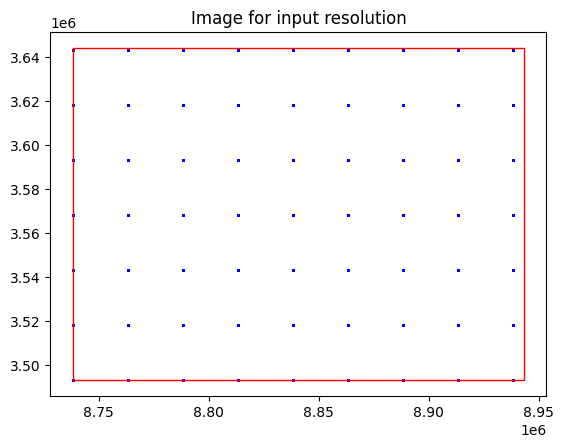

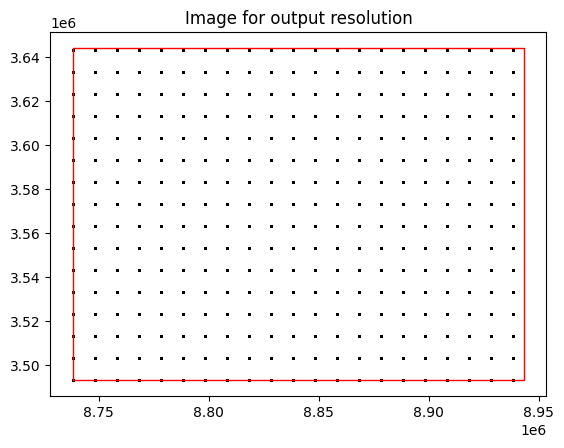

lenghts of x_values,y_values,x_values_output,y_values_output:  9 7 21 16


In [19]:
if __name__ == "__main__":
    xc_inp,yc_inp,xc_out,yc_out,grids=res_change(minx, miny, maxx, maxy, input_res=25000, output_res=10000)

In [20]:
grid=[]
for cell in grids:
    polygon = Polygon(list(zip(cell['X'], cell['Y'])))
    grid.append(polygon)

grid_gdf = gpd.GeoDataFrame({'geometry': grid}, crs=shape_file.crs)

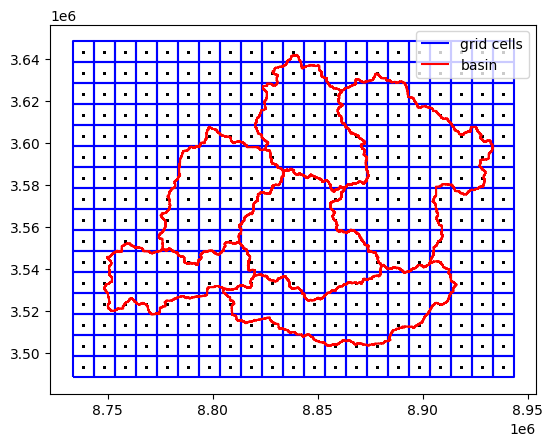

In [21]:
fig, ax = plt.subplots()
ax.scatter(xc_out, yc_out, s=1, color='black')
grid_gdf.boundary.plot(ax=ax, color='blue', label='grid cells')
shape_file.boundary.plot(ax=ax, color='red',label='basin')
plt.legend()
plt.show()

In [22]:
#seeing the dims of 0.1 resolution grid
# yc - rows, xc - columns
print("dims of grid= ",(((yc_out[len(yc_out)-1][0] - yc_out[0][0]) // 10000,(xc_out[0][len(xc_out[0])-1] - xc_out[0][0]) // 10000)))

dims of grid=  (np.float64(15.0), np.float64(20.0))


In [23]:
#seein the dims of 0.25 resolution grid
print("dims of grid= ",(((yc_inp[len(yc_inp)-1][0] - yc_inp[0][0]) //25000,(xc_inp[0][len(xc_inp[0])-1] - xc_inp[0][0]) //25000)))

dims of grid=  (np.float64(6.0), np.float64(8.0))


In [28]:
#with the 0.1 grid
print("extent in y and x (in km): ",(yc_out[len(yc_out)-1][0] - yc_out[0][0])//1000,
(xc_out[0][len(xc_out[0])-1] - xc_out[0][0])//1000)
#with the 0.25 grid
#print("extent in y and x (in km): ",(yc_inp[len(yc_inp)-1][0] - yc_inp[0][0])//1000,
#(xc_inp[0][len(xc_inp[0])-1] - xc_inp[0][0])//1000)

extent in y and x (in km):  150.0 200.0
